# Classifying newswires with tf.keras and tf.data.

In this notebook, you'll learn how to classify newswires from the [Reuters dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters) into categories. This tutorial was inspired by [this one](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.6-classifying-newswires.ipynb). This notebook is similar to previous one. The principal difference is here, we will explore a multiclass text classification problem.

In [1]:
import tensorflow as tf

import numpy as np


## A first look at the dataset

### Step 1) Downloading the dataset

The dataset consists of a set of short [newswires](https://www.google.com/search?q=what+is+a+newswire) and their corresponding topics as published by Reuters in 1986 (the year Madonna's Papa Don't Preach came out, although I preferred You Can Call Me Al by Paul Simon 🎺).

In [2]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.reuters.load_data(num_words=10000)

### Step 2) Exploring the dataset 

There are around 46 different topics. The set is divided into 8982 training examples and 2246 test examples. Each training example is a list of words represented as integers similar to the IMDB dataset, and the labels are integers up to 46.

In [3]:
print(train_data[0])
print(train_labels[0])
print(len(train_data))
print(len(test_data))

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3
8982
2246


### Converting the integers to words

We can get the dictionary from `tf.keras.datasets.reuters.get_word_index` which hashes the words to their corresponding integers. Let's try and convert a newswire from integers back into it's original text by first reversing this dictionary and then iterating over a newswire and converting the integers to strings.

In [4]:
# Dictionary that hashes words to their integer
word_to_integer = tf.keras.datasets.reuters.get_word_index()

In [5]:
print(list(word_to_integer.keys())[0:10])

integer_to_word = dict([(value, key) for (key, value) in word_to_integer.items()])

# Demonstrate how to find the word from an integer
print(integer_to_word[1])
print(integer_to_word[2])

import random

random_index = random.randint(0, 100)
# We need to subtract 3 from the indices because 0 is "padding", 1 is "start of sequence", and 2 is "unknown"
decoded_newswire = ' '.join([integer_to_word.get(i - 3, 'UNK') for i in train_data[random_index]])
print(decoded_newswire)
print(train_labels[random_index])

['mdbl', 'fawc', 'degussa', 'woods', 'hanging', 'localized', 'sation', 'chanthaburi', 'refunding', 'hermann']
the
of
UNK year to december 31 world group pre tax profit 2 63 billion marks vs 3 04 billion world group turnover 40 47 billion vs 44 38 billion world group investment in fixed assets 2 66 billion vs 2 46 billion parent company pre tax profit 1 97 billion vs 1 91 billion parent turnover 18 72 billion vs 20 46 billion parent domestic turnover 7 10 billion vs 8 14 billion parent foreign turnover 11 62 billion vs 12 32 billion parent investment in fixed assets 1 14 billion vs 884 mln reuter 3
3


### Step 3) Format the data
As before, we are going to multi-hot encode our newswire which is an array of integers into a 10,000 dimensional vector. We will place 1's in the indices of word-integers that occur in the newswire, and 0's for everything else.

In [6]:
def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results


train_data = vectorize_sequences(train_data)
test_data = vectorize_sequences(test_data)

print(train_data.shape)
print(train_data[0])

(8982, 10000)
[0. 1. 1. ... 0. 0. 0.]


### Step 4) Format the labels

We will also use [tf.keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) to one hot encode our labels.

In [7]:
LABEL_DIMENSIONS = 46

print(train_labels[0]) # Before
train_labels  = tf.keras.utils.to_categorical(train_labels, LABEL_DIMENSIONS)
print(train_labels[0]) # After

test_labels = tf.keras.utils.to_categorical(test_labels, LABEL_DIMENSIONS)

# Needed later
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

3
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Step 5) Create the model

Our model is similar to the previous notebook, modified to work for a multiclass classification problem.

In [8]:
### Create a model
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(10000,)))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(LABEL_DIMENSIONS, activation=tf.nn.softmax))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


### Step 6) Validation set

As before, we want to test our model on data it hasn't seen before, but before we get our final test accuracy. Here, we'll create a validation set.

In [9]:
VAL_SIZE = 1000

val_data = train_data[:VAL_SIZE]
partial_train_data = train_data[VAL_SIZE:]


val_labels = train_labels[:VAL_SIZE]
partial_train_labels = train_labels[VAL_SIZE:]

### Step 7) Create a tf.data Dataset

In [10]:
BATCH_SIZE = 512
TRAINING_SIZE = partial_train_labels.shape[0]

training_set = tf.data.Dataset.from_tensor_slices((partial_train_data, partial_train_labels))
training_set = training_set.shuffle(TRAINING_SIZE).batch(BATCH_SIZE)

### Step 8) Training your model
Please be patient as this step may take a while.

In [11]:
EPOCHS = 20

# Store list of metric values for plotting later
tr_loss_list = []
tr_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

for epoch in range(EPOCHS):
    for newswires, labels in training_set:
        # Calculate training loss and accuracy
        tr_loss, tr_accuracy = model.train_on_batch(newswires, labels)
  
    # Calculate validation loss and accuracy
    val_loss, val_accuracy = model.evaluate(val_data, val_labels)

    # Add to the lists
    tr_loss_list.append(tr_loss)
    tr_accuracy_list.append(tr_accuracy)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)
  
    print(('Epoch #%d\t Training Loss: %.2f\tTraining Accuracy: %.2f\t'
           'Validation Loss: %.2f\tValidation Accuracy: %.2f') % (epoch + 1, 
                                                                  tr_loss, 
                                                                  tr_accuracy,
                                                                  val_loss, 
                                                                  val_accuracy))

1000/1000==============================] - 0s 112us/sample - loss: 1.7716 - acc: 0.6540
Epoch #1	 Training Loss: 1.94	Training Accuracy: 0.62	Validation Loss: 1.77	Validation Accuracy: 0.65
1000/1000==============================] - 0s 75us/sample - loss: 1.3295 - acc: 0.7220
Epoch #2	 Training Loss: 1.31	Training Accuracy: 0.73	Validation Loss: 1.33	Validation Accuracy: 0.72
1000/1000==============================] - 0s 63us/sample - loss: 1.1428 - acc: 0.7590
Epoch #3	 Training Loss: 0.98	Training Accuracy: 0.81	Validation Loss: 1.14	Validation Accuracy: 0.76
1000/1000==============================] - 0s 63us/sample - loss: 1.0469 - acc: 0.7760
Epoch #4	 Training Loss: 0.74	Training Accuracy: 0.86	Validation Loss: 1.05	Validation Accuracy: 0.78
1000/1000==============================] - 0s 62us/sample - loss: 0.9862 - acc: 0.7910
Epoch #5	 Training Loss: 0.57	Training Accuracy: 0.89	Validation Loss: 0.99	Validation Accuracy: 0.79
1000/1000==============================] - 0s 65us/sam

### Step 9) Plotting your loss and accuracy
We are going to use `matplotlib` to plot our training and validation metrics.

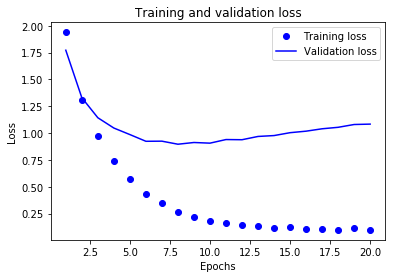

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

# "bo" specifies "blue dot"
plt.plot(epochs, tr_loss_list, 'bo', label='Training loss')
# b specifies a "solid blue line"
plt.plot(epochs, val_loss_list, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

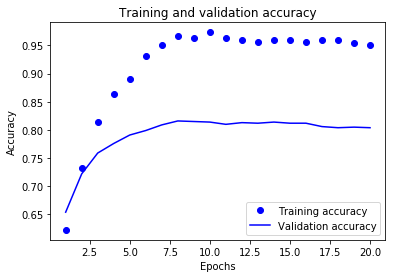

In [13]:
plt.clf()   # Clear plot

plt.plot(epochs, tr_accuracy_list, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy_list, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Step 10) Testing your model
Now that we have successfully trained our model and our training accuracy has jumped over 90%, we need to test it. The test accuracy is a better evaluation metric for how our model will perform in the real world.

In [14]:
loss, accuracy = model.evaluate(test_data, test_labels)
print('Test accuracy: %.2f' % (accuracy))

2246/2246==============================] - 0s 63us/sample - loss: 1.2530 - acc: 0.7765
Test accuracy: 0.78
